## Example GradCAM

In [31]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the image
image_path = '/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/DA-AFNet/asian_elephant.jpg'
img = Image.open(image_path)

# Apply transformations
img_tensor = transform(img).unsqueeze(0)  # Add batch dimension

print("Image tensor shape:", img_tensor.shape)


Image tensor shape: torch.Size([1, 3, 224, 224])


In [32]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)

In [33]:
vgg = VGG()

# set the evaluation mode
vgg.eval()

# get the most likely prediction of the model
pred = vgg(img_tensor)

/home/desktop/anaconda3/envs/cogmusic/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/desktop/anaconda3/envs/cogmusic/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [34]:
vgg

VGG(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Conv2d

In [35]:
torch.max(pred, dim=1)

torch.return_types.max(
values=tensor([29.8366], grad_fn=<MaxBackward0>),
indices=tensor([385]))

torch.Size([1, 512, 14, 14])
torch.Size([512])
torch.Size([1, 512, 14, 14])
torch.Size([1, 512, 14, 14])
torch.Size([14, 14])


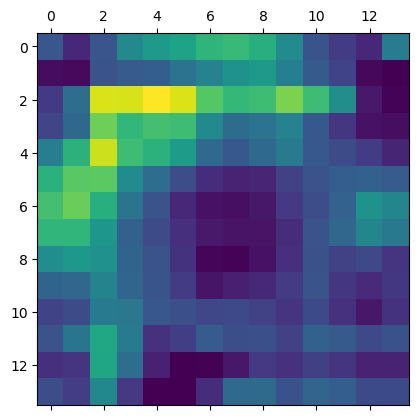

In [ ]:
pred[:,385].backward()

gradients = vgg.get_activations_gradient()
print(gradients.shape)

# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
print(pooled_gradients.shape)
# get the activations of the last convolutional layer
activations = vgg.get_activations(img_tensor).detach()
print(activations.shape)
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]
print(activations.shape) 
# average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()
print(heatmap.shape)
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

# normalize the heatmap
heatmap /= torch.max(heatmap)

# draw the heatmap
plt.matshow(heatmap.squeeze())

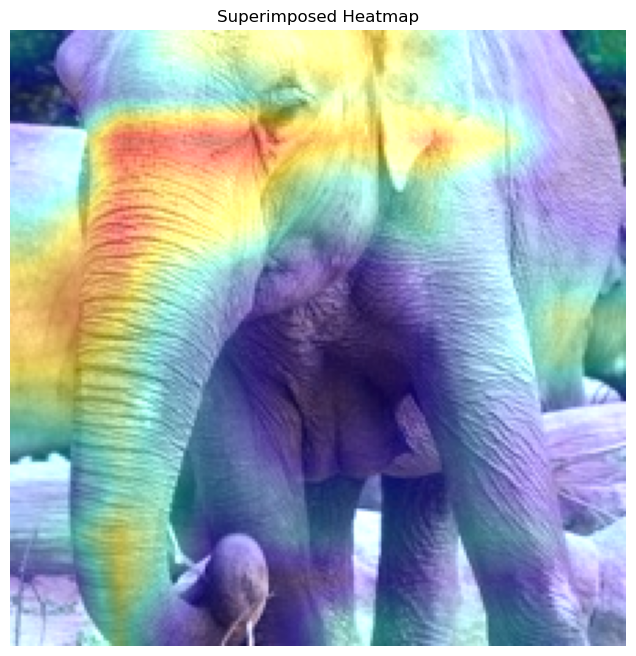

In [37]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('/home/desktop/Desktop/22104412_Docs/EEG-COGMusic/DA-AFNet/asian_elephant.jpg')
heatmap = cv2.resize(heatmap.numpy(), (img.shape[1], img.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img

superimposed_img = np.clip(superimposed_img, 0, 255).astype('uint8')

# Convert BGR (OpenCV format) to RGB (matplotlib format)
superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)

# Display the image using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(superimposed_img_rgb)
plt.axis('off')  # Hide axis
plt.title("Superimposed Heatmap")
plt.show()